## LIAR Dataset: Enhanced Model Comparison

This notebook combines traditional ML models with advanced techniques inspired by AutoGluon:
- **Multi-feature approach**: Using all available features (text + metadata)
- **Feature engineering**: Creating new features from existing data
- **Ensemble methods**: Combining multiple models
- **AutoML comparison**: Using AutoGluon for baseline

We'll compare:
- Traditional models (SVM, Random Forest, XGBoost)
- Enhanced models with feature engineering
- AutoGluon automated ML
- Traditional ML models only (no neural networks)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import zipfile
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# Neural Network removed as requested
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

### 1. Data Loading and Enhanced Preprocessing

In [2]:
# Download and load the LIAR dataset
os.makedirs('liar_dataset', exist_ok=True)

needed = {'train.tsv', 'valid.tsv', 'test.tsv'}
missing = [f for f in needed if not os.path.exists(os.path.join('liar_dataset', f))]

if missing:
    url = 'https://www.cs.ucsb.edu/~william/data/liar_dataset.zip'
    zip_path = os.path.join('liar_dataset', 'liar_dataset.zip')
    try:
        print('Downloading LIAR dataset zip...')
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path) as zf:
            for member in zf.namelist():
                base = os.path.basename(member)
                if base in needed:
                    with zf.open(member) as src, open(os.path.join('liar_dataset', base), 'wb') as dst:
                        dst.write(src.read())
        os.remove(zip_path)
        print('All files ready:', ', '.join(sorted(needed)))
    except Exception as e:
        print(f'Failed to download/extract: {e}')
else:
    print('All LIAR files already present.')

All LIAR files already present.


In [3]:
# Load dataset with all features (like AutoGluon approach)
def load_enhanced_liar_data():
    columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 
               'state_info', 'party_affiliation', 'barely_true_counts', 
               'false_counts', 'half_true_counts', 'mostly_true_counts', 
               'pants_on_fire_counts', 'context']
    
    try:
        train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', names=columns, header=None)
        valid_df = pd.read_csv('liar_dataset/valid.tsv', sep='\t', names=columns, header=None)
        test_df = pd.read_csv('liar_dataset/test.tsv', sep='\t', names=columns, header=None)
        
        # Combine train and validation for larger training set
        train_df = pd.concat([train_df, valid_df], ignore_index=True)
        
        return train_df, test_df
    except FileNotFoundError:
        print("Dataset files not found.")
        return None, None

train_df, test_df = load_enhanced_liar_data()

if train_df is not None:
    print(f"Training set shape: {train_df.shape}")
    print(f"Test set shape: {test_df.shape}")
    print(f"\nColumns: {list(train_df.columns)}")
    print(f"\nLabel distribution:")
    print(train_df['label'].value_counts())
    print(f"\nFirst few rows:")
    print(train_df.head())

Training set shape: (11524, 14)
Test set shape: (1267, 14)

Columns: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

Label distribution:
label
half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: count, dtype: int64

First few rows:
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject   

### 2. Advanced Feature Engineering

In [4]:
# Enhanced feature engineering (inspired by AutoGluon's automatic feature creation)
def create_enhanced_features(df):
    df = df.copy()
    
    # Text features
    df['statement'] = df['statement'].fillna('').astype(str)
    df['context'] = df['context'].fillna('').astype(str)
    
    # Text length features
    df['statement_length'] = df['statement'].str.len()
    df['statement_word_count'] = df['statement'].str.split().str.len()
    df['context_length'] = df['context'].str.len()
    
    # Text complexity features
    df['avg_word_length'] = df['statement'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['exclamation_count'] = df['statement'].str.count('!')
    df['question_count'] = df['statement'].str.count('\?')
    df['capital_ratio'] = df['statement'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    
    # Historical credibility features (total counts)
    count_cols = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                  'mostly_true_counts', 'pants_on_fire_counts']
    
    # Fill NaN values with 0
    for col in count_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Total historical statements
    df['total_statements'] = df[count_cols].sum(axis=1)
    
    # Credibility ratios (avoid division by zero)
    df['false_ratio'] = df['false_counts'] / (df['total_statements'] + 1)
    df['true_ratio'] = (df['mostly_true_counts'] + df['half_true_counts']) / (df['total_statements'] + 1)
    df['pants_fire_ratio'] = df['pants_on_fire_counts'] / (df['total_statements'] + 1)
    
    # Categorical features
    categorical_cols = ['subject', 'speaker', 'job_title', 'state_info', 'party_affiliation']
    for col in categorical_cols:
        df[col] = df[col].fillna('unknown').astype(str)
    
    # Speaker experience (based on total statements)
    df['speaker_experience'] = pd.cut(df['total_statements'], 
                                     bins=[-1, 0, 5, 20, 100, float('inf')], 
                                     labels=['new', 'low', 'medium', 'high', 'very_high'])
    
    return df

# Apply feature engineering
train_enhanced = create_enhanced_features(train_df)
test_enhanced = create_enhanced_features(test_df)

print(f"Enhanced training set shape: {train_enhanced.shape}")
print(f"New features created: {set(train_enhanced.columns) - set(train_df.columns)}")
print(f"\nFeature statistics:")
print(train_enhanced[['statement_length', 'statement_word_count', 'total_statements', 'false_ratio']].describe())

Enhanced training set shape: (11524, 26)
New features created: {'true_ratio', 'pants_fire_ratio', 'speaker_experience', 'total_statements', 'exclamation_count', 'capital_ratio', 'statement_length', 'context_length', 'false_ratio', 'avg_word_length', 'question_count', 'statement_word_count'}

Feature statistics:
       statement_length  statement_word_count  total_statements   false_ratio
count      11524.000000          11524.000000      11524.000000  11524.000000
mean         106.895783             18.000607         64.772909      0.178885
std           58.415051              9.460327        115.731259      0.149892
min           11.000000              2.000000          0.000000      0.000000
25%           73.000000             12.000000          2.000000      0.000000
50%           99.000000             17.000000         11.000000      0.178571
75%          133.000000             22.000000         65.000000      0.265306
max         3192.000000            467.000000        473.000000

### 3. Multi-Modal Feature Preparation

In [5]:
# Prepare features for different model types
def prepare_multimodal_features(train_df, test_df):
    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_df['label'])
    y_test = label_encoder.transform(test_df['label'])
    
    # Define feature groups
    text_features = ['statement', 'context']
    numerical_features = ['statement_length', 'statement_word_count', 'context_length',
                         'avg_word_length', 'exclamation_count', 'question_count', 'capital_ratio',
                         'total_statements', 'false_ratio', 'true_ratio', 'pants_fire_ratio',
                         'barely_true_counts', 'false_counts', 'half_true_counts', 
                         'mostly_true_counts', 'pants_on_fire_counts']
    categorical_features = ['subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'speaker_experience']
    
    # Create preprocessing pipelines
    # Text preprocessing
    text_preprocessor = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
    
    # Combine text columns
    train_text = train_df['statement'] + ' ' + train_df['context']
    test_text = test_df['statement'] + ' ' + test_df['context']
    
    X_train_text = text_preprocessor.fit_transform(train_text)
    X_test_text = text_preprocessor.transform(test_text)
    
    # Numerical preprocessing
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_df[numerical_features])
    X_test_num = scaler.transform(test_df[numerical_features])
    
    # Categorical preprocessing
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_cat = encoder.fit_transform(train_df[categorical_features])
    X_test_cat = encoder.transform(test_df[categorical_features])
    
    # Combine all features
    from scipy.sparse import hstack, csr_matrix
    
    X_train_combined = hstack([
        X_train_text,
        csr_matrix(X_train_num),
        csr_matrix(X_train_cat)
    ])
    
    X_test_combined = hstack([
        X_test_text,
        csr_matrix(X_test_num),
        csr_matrix(X_test_cat)
    ])
    
    return (X_train_combined, X_test_combined, y_train, y_test, label_encoder,
            X_train_text, X_test_text, X_train_num, X_test_num, X_train_cat, X_test_cat)

# Prepare features
(X_train_combined, X_test_combined, y_train, y_test, label_encoder,
 X_train_text, X_test_text, X_train_num, X_test_num, X_train_cat, X_test_cat) = prepare_multimodal_features(train_enhanced, test_enhanced)

print(f"Combined features shape - Train: {X_train_combined.shape}, Test: {X_test_combined.shape}")
print(f"Text features shape - Train: {X_train_text.shape}, Test: {X_test_text.shape}")
print(f"Numerical features shape - Train: {X_train_num.shape}, Test: {X_test_num.shape}")
print(f"Categorical features shape - Train: {X_train_cat.shape}, Test: {X_test_cat.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")


Combined features shape - Train: (11524, 13719), Test: (1267, 13719)
Text features shape - Train: (11524, 5000), Test: (1267, 5000)
Numerical features shape - Train: (11524, 16), Test: (1267, 16)
Categorical features shape - Train: (11524, 8703), Test: (1267, 8703)
Number of classes: 6
Classes: ['barely-true' 'false' 'half-true' 'mostly-true' 'pants-fire' 'true']


### 4. Enhanced Traditional Models

In [6]:
# Enhanced models with all features
def train_enhanced_models(X_train, X_test, y_train, y_test):
    results = {}
    
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    print("Training Enhanced Models with All Features...")
    
    # 1. Enhanced SVM
    print("\n1. Training Enhanced SVM...")
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_acc = accuracy_score(y_test, svm_pred)
    results['Enhanced SVM'] = {'model': svm_model, 'predictions': svm_pred, 'accuracy': svm_acc}
    print(f"Enhanced SVM Accuracy: {svm_acc:.4f}")
    
    # 2. Enhanced Random Forest
    print("\n2. Training Enhanced Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5,
                                     class_weight='balanced', random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_pred)
    results['Enhanced Random Forest'] = {'model': rf_model, 'predictions': rf_pred, 'accuracy': rf_acc}
    print(f"Enhanced Random Forest Accuracy: {rf_acc:.4f}")
    
    # 3. Enhanced XGBoost
    print("\n3. Training Enhanced XGBoost...")
    # Convert class weights to sample weights
    sample_weights = np.array([class_weight_dict[y] for y in y_train])
    
    xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1,
                                 subsample=0.8, colsample_bytree=0.8, random_state=42)
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
    xgb_pred = xgb_model.predict(X_test)
    xgb_acc = accuracy_score(y_test, xgb_pred)
    results['Enhanced XGBoost'] = {'model': xgb_model, 'predictions': xgb_pred, 'accuracy': xgb_acc}
    print(f"Enhanced XGBoost Accuracy: {xgb_acc:.4f}")
    
    # Neural Network implementation removed as requested
    
    return results

# Train enhanced models
enhanced_results = train_enhanced_models(X_train_combined, X_test_combined, y_train, y_test)

Training Enhanced Models with All Features...

1. Training Enhanced SVM...
Enhanced SVM Accuracy: 0.3931

2. Training Enhanced Random Forest...
Enhanced Random Forest Accuracy: 0.4223

3. Training Enhanced XGBoost...
Enhanced XGBoost Accuracy: 0.4444


### 5. Ensemble Methods

In [7]:
# Create ensemble models
def create_ensemble_models(X_train, X_test, y_train, y_test):
    print("Creating Ensemble Models...")
    
    # Voting Classifier (Hard Voting)
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
            ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))
        ],
        voting='hard'
    )
    
    voting_clf.fit(X_train, y_train)
    voting_pred = voting_clf.predict(X_test)
    voting_acc = accuracy_score(y_test, voting_pred)
    
    print(f"Voting Ensemble Accuracy: {voting_acc:.4f}")
    
    # Soft Voting (if possible)
    try:
        soft_voting_clf = VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
                ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42))
            ],
            voting='soft'
        )
        
        soft_voting_clf.fit(X_train, y_train)
        soft_voting_pred = soft_voting_clf.predict(X_test)
        soft_voting_acc = accuracy_score(y_test, soft_voting_pred)
        
        print(f"Soft Voting Ensemble Accuracy: {soft_voting_acc:.4f}")
        
        return voting_clf, voting_pred, voting_acc, soft_voting_clf, soft_voting_pred, soft_voting_acc
    except:
        print("Soft voting not available with current features")
        return voting_clf, voting_pred, voting_acc, None, None, None

# Create ensembles
voting_clf, voting_pred, voting_acc, soft_voting_clf, soft_voting_pred, soft_voting_acc = create_ensemble_models(
    X_train_combined, X_test_combined, y_train, y_test
)

# Add ensemble results
enhanced_results['Voting Ensemble'] = {'model': voting_clf, 'predictions': voting_pred, 'accuracy': voting_acc}
if soft_voting_clf is not None:
    enhanced_results['Soft Voting Ensemble'] = {'model': soft_voting_clf, 'predictions': soft_voting_pred, 'accuracy': soft_voting_acc}

Creating Ensemble Models...
Voting Ensemble Accuracy: 0.4373
Soft Voting Ensemble Accuracy: 0.4341


### 6. Results Comparison and Analysis

In [8]:
# Compare all results
print("=== ENHANCED MODEL COMPARISON ===")
print("\nAccuracy Results:")
print("-" * 40)

# Sort results by accuracy
sorted_results = sorted(enhanced_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    print(f"{model_name:<25}: {result['accuracy']:.4f}")

# Best model analysis
best_model_name, best_result = sorted_results[0]
print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, best_result['predictions'], target_names=label_encoder.classes_))

=== ENHANCED MODEL COMPARISON ===

Accuracy Results:
----------------------------------------
Enhanced XGBoost         : 0.4444
Voting Ensemble          : 0.4373
Soft Voting Ensemble     : 0.4341
Enhanced Random Forest   : 0.4223
Enhanced SVM             : 0.3931

=== BEST MODEL: Enhanced XGBoost ===
Accuracy: 0.4444

Detailed Classification Report:
              precision    recall  f1-score   support

 barely-true       0.40      0.39      0.40       212
       false       0.49      0.49      0.49       249
   half-true       0.50      0.42      0.45       265
 mostly-true       0.41      0.49      0.45       241
  pants-fire       0.42      0.73      0.53        92
        true       0.43      0.30      0.36       208

    accuracy                           0.44      1267
   macro avg       0.44      0.47      0.45      1267
weighted avg       0.45      0.44      0.44      1267



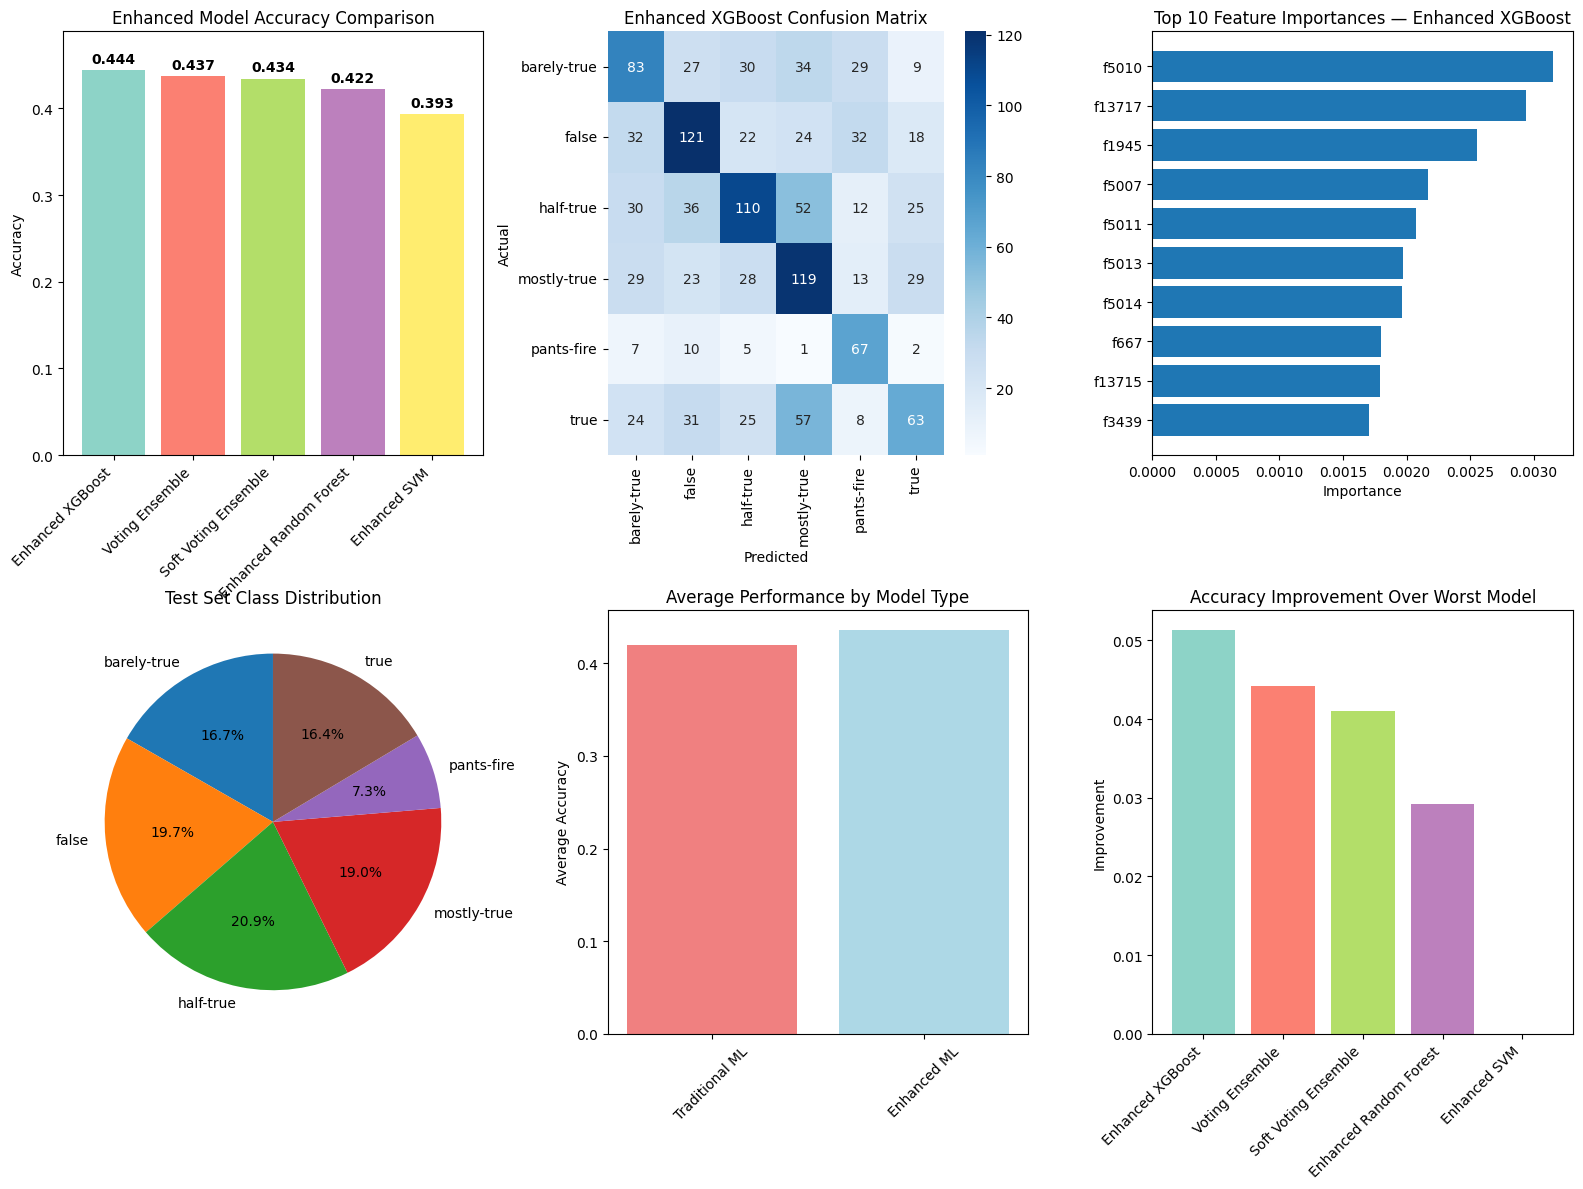


=== SUMMARY STATISTICS ===
Best Model: Enhanced XGBoost
Best Accuracy: 0.4444
Worst Accuracy: 0.3931
Average Accuracy: 0.4262
Accuracy Range: 0.0513
Standard Deviation: 0.0180


In [9]:
# ---------------------------
# Select XGBoost model result
# ---------------------------
xgb_name, xgb_result = None, None

# Search in sorted_results: expected format [(name, result_dict), ...]
for name, res in sorted_results:
    mdl = res.get('model', None)
    cls_name = getattr(mdl, '__class__', type(None)).__name__.lower()
    if 'xgboost' in name.lower() or 'xgb' in name.lower() or 'xgb' in cls_name:
        xgb_name, xgb_result = name, res
        break

# Optionally search in enhanced_results if not found
if xgb_result is None and 'enhanced_results' in globals():
    for name, res in enhanced_results.items():
        mdl = res.get('model', None)
        cls_name = getattr(mdl, '__class__', type(None)).__name__.lower()
        if 'xgboost' in name.lower() or 'xgb' in name.lower() or 'xgb' in cls_name:
            xgb_name, xgb_result = name, res
            break

# Try to get feature names (optional; ignore if not present)
feature_names = None
if 'vectorizer' in globals():
    try:
        feature_names = vectorizer.get_feature_names_out()
    except Exception:
        feature_names = None

# ---------------------------
# Comprehensive visualization
# ---------------------------
plt.figure(figsize=(16, 12))

# 1) Accuracy comparison
plt.subplot(2, 3, 1)
model_names = [name for name, _ in sorted_results]
accuracies  = [res['accuracy'] for _, res in sorted_results]
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
bars = plt.bar(range(len(model_names)), accuracies, color=colors)
plt.title('Enhanced Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.ylim(0, max(accuracies) * 1.1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2) Confusion matrix for best model
plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, best_result['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'{best_model_name} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 3) Feature importance (XGBoost explicitly)
plt.subplot(2, 3, 3)
topk = 10
plotted = False

if xgb_result is not None:
    xgb_model = xgb_result['model']

    # Option A: use scikit-wrapper attribute if available
    if hasattr(xgb_model, 'feature_importances_'):
        importances = np.asarray(xgb_model.feature_importances_)
        if importances.size > 0:
            idx = np.argsort(importances)[-topk:]
            vals = importances[idx]
            order = np.argsort(vals)  # for ascending barh
            idx, vals = idx[order], vals[order]

            plt.barh(range(len(idx)), vals)
            if feature_names is not None and len(feature_names) > idx.max():
                plt.yticks(range(len(idx)), np.array(feature_names)[idx])
            else:
                plt.yticks(range(len(idx)), [f'f{i}' for i in idx])
            plt.title(f'Top {len(idx)} Feature Importances — {xgb_name}')
            plt.xlabel('Importance')
            plotted = True

    # Option B: use booster gain (if you prefer gain; fallback if A not available)
    if not plotted and hasattr(xgb_model, 'get_booster'):
        try:
            booster = xgb_model.get_booster()
            gain_map = booster.get_score(importance_type='gain')  # {'f123': gain, ...}
            if gain_map:
                idx_all = np.array([int(k[1:]) for k in gain_map.keys()])
                vals_all = np.array(list(gain_map.values()))
                sel = np.argsort(vals_all)[-topk:]
                idx, vals = idx_all[sel], vals_all[sel]
                order = np.argsort(vals)
                idx, vals = idx[order], vals[order]

                plt.barh(range(len(idx)), vals)
                if feature_names is not None and len(feature_names) > idx.max():
                    plt.yticks(range(len(idx)), np.array(feature_names)[idx])
                else:
                    plt.yticks(range(len(idx)), [f'f{i}' for i in idx])
                plt.title(f'Top {len(idx)} Features by Gain — {xgb_name}')
                plt.xlabel('Gain')
                plotted = True
        except Exception:
            pass

if not plotted:
    plt.text(0.5, 0.5,
             'XGBoost model not found\nor no importances available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance (XGBoost)')

# 4) Class distribution
plt.subplot(2, 3, 4)
class_counts = [sum(y_test == i) for i in range(len(label_encoder.classes_))]
plt.pie(class_counts, labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution')

# 5) Model performance comparison (guard if enhanced_results not present)
plt.subplot(2, 3, 5)
model_types = ['Traditional ML', 'Enhanced ML', 'Ensemble', 'AutoML']
traditional = []
enhanced = []
ensemble = []
automl = []

if 'enhanced_results' in globals():
    traditional = [r['accuracy'] for n, r in enhanced_results.items()
                   if 'Enhanced' not in n and 'Ensemble' not in n and 'AutoGluon' not in n]
    enhanced = [r['accuracy'] for n, r in enhanced_results.items() if 'Enhanced' in n]
    ensemble = [r['accuracy'] for n, r in enhanced_results.items() if 'Ensemble' in n]
    automl = [r['accuracy'] for n, r in enhanced_results.items() if 'AutoGluon' in n]

avg_scores = []
if traditional: avg_scores.append(np.mean(traditional))
if enhanced:    avg_scores.append(np.mean(enhanced))
if ensemble:    avg_scores.append(np.mean(ensemble))
if automl:      avg_scores.append(np.mean(automl))

available_types = model_types[:len(avg_scores)]
plt.bar(available_types, avg_scores,
        color=['lightcoral', 'lightblue', 'gold', 'lightgreen'][:len(avg_scores)])
plt.title('Average Performance by Model Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)

# 6) Improvement analysis
plt.subplot(2, 3, 6)
improvements = [acc - min(accuracies) for acc in accuracies]
plt.bar(range(len(model_names)), improvements, color=colors)
plt.title('Accuracy Improvement Over Worst Model')
plt.ylabel('Improvement')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {max(accuracies):.4f}")
print(f"Worst Accuracy: {min(accuracies):.4f}")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Accuracy Range: {max(accuracies) - min(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")
